CMPUT340 - Replacement Project
By: Daniel Merryweather (1580298 - dmerrywe)

In this project I have chosen to take inspiration from Project Topic #2, where I have built upon Lab 5 and implemented Convolutional layers to improve image classification of the MNIST dataset. Further to show the difference between a basic feed forward neural network and a basic convolutional neural network I will also test them against the CIFAR 10 dataset.

For simplicity I will use the keras implementation of Conv2D and MaxPooling layers. To keep it fair I have also re-written Lab 5 using TensorFlow/keras functions to isolate optimization in implementation. Both will still use Simple Gradient Descent to perform training.

The purpose of this project is to show the difference between using a basic feed forward neural network versus convolutional neural networks in image classification.

In [11]:
# Imports

from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

First I shall gather the data from the MNIST dataset.

I created a function to make this process a bit simpler. First I truncate the data to a specific training size then normalize the pixel values that originally range from 0 to 255 into a decimal value between 0 and 1.
Next I handle label similarly to how it was provided in Lab5, simply enumerating the index and label index to create a one hot vector for each label.

In [12]:
# Data formatting

trainingSize = 20000

print("Training set size: " + str(trainingSize)) # Print size of training set

# gatherTrainingData: xData, yDate, size
#    returns x and y training data after conversion and truncation
def gatherTrainingData(xData, yData, size=-1):
    x = xData[:size]
    x = x / 255 # normalize pixel values from 0-255 to 0-1
    y = np.zeros((size, 10))
    for index, value in enumerate(yData[:size]):
        y[index][value] = 1
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data() # Gather training data
xTrainingData, yTrainingData = gatherTrainingData(x_train, y_train, size=trainingSize)

Training set size: 20000


Next I create the model's using keras Sequential models.

For the lab 5 model I first flatten the data into a single vector using a Flatten layer. This feeds into a Dense layer with 10 nodes, dense layers will create a weight parameter for every node in the previous connected to every node in the dense layer. Further setting use_bias will specify a bias value for every node in the dense layer.

Altogether this will create 28*28*10 weights and 10 biases. Exactly the same as Lab 5.

For the convolutional model I use 2 convolutional layers, both with 5x5 kernal sizes that both feed into their respective MaxPooling layer which will give the maximal values for every 2x2 sub matrix in the output from the convolutional layer. Finally I flatten the data and put it through a 10 node dense layer.

The number of convolutional filters I chose for each layer were decided based on how close I could get the total parameters to match and be less than the lab 5 model.

Altogether the first convolutional layer has 260 parameters, the second convolutional layer has 4518 parameters and finally the dense layer has 2890 parameters for a total of 7668 parameters in the convolutional model.

Ensuring that the convolutional model has slightly less parameters than the regular feed
forward model from lab 5 will highlight the efficiency of using convolutional layers.

In [13]:
# Model functions

def lab5model():
    model = Sequential([
        Flatten(input_shape=(28,28)), # Flatten data (no params)
        Dense(10, use_bias=True) # Dense layer 28*28*10 weights 10 biases
    ], name="Lab5Model")
    return model

def convolutionalModel():
    model = Sequential([
        Conv2D(10, (5,5), input_shape=(28,28,1)), # 10 filter convolutional layer with 5x5 kernal
        MaxPooling2D(pool_size=(2,2)), # Max pooling layer with 2x2 sub matrix grouping (no params)
        Conv2D(18, (5,5)), # 18 filter convolutional layer with 5x5 kernal
        MaxPooling2D(pool_size=(2,2)), # Final max pooling layer with 2x2 sub matrix grouping (no params)
        Flatten(), # Flatten data (no params)
        Dense(10, use_bias=True) # Dense layer with 10 nodes.
    ], name="ConvolutionalModel")
    return model

Staying true to lab 5, I compile the model's using SDG (simple gradient descent) and calculate loss (error) using mean squared error.

For more detail on the model's I print their summaries below.

In [14]:
# Compiling models

lab5m = lab5model()
convm = convolutionalModel()

# Learning rate
alpha = 0.01

# Compile models to improve based on Simple Gradient Descent and Mean Squared Erro
lab5m.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
convm.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

# Print model summaries
lab5m.summary()
convm.summary()

Model: "Lab5Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Model: "ConvolutionalModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 18)          4518      
___________________________

Going forward, I train the models.

The X training data needs to have another dimension to properly be handled in
the convolutional layer, so I reshape the data to fit a 28x28x1 3 dimensional array.

Initially I evaluate the untrained models for their initial accuracy on the
training dataset, this will come into play further on. Then I keep track of the history of accuracy after every epoch of training, which is every training pass through the entire dataset.

Finally I convert the test data to the correct format and make sure that both models perform decently on data it has not seen before, this step is to ensure there is no overfitting in either model.

Note: Training can take up to about 5 minutes to complete.

In [15]:
# Training section

# Reshape xTrainingData for input to convolutional layer
xConvTrainingData = xTrainingData.reshape([-1, 28, 28, 1])

# Training epochs
numberOfEpochs = 10

verb = 0 # If you would like to see the progress of each epoch of training set this to 1

# Find initial accuracy before training
lab5InitAcc = lab5m.evaluate(xTrainingData, yTrainingData, verbose=verb)[1]
convInitAcc = convm.evaluate(xConvTrainingData, yTrainingData, verbose=verb)[1]

# Traing models
lab5mHistory = lab5m.fit(xTrainingData, yTrainingData, epochs=numberOfEpochs, verbose=verb)
convmHistory = convm.fit(xConvTrainingData, yTrainingData, epochs=numberOfEpochs, verbose=verb)


# Test models on data they have not trained on

testSize = 10000

xTestData, yTestData = gatherTrainingData(x_test, y_test, size=testSize)
xConvTestData = xTestData.reshape([-1, 28, 28, 1])

print("Testing Lab 5 Model on new Test Data: ")
lab5m.evaluate(xTestData, yTestData)
print("Testing Convolutional Model on new Test Data: ")
convm.evaluate(xConvTestData, yTestData)


Testing Lab 5 Model on new Test Data: 
10000/10000 [==============================] - 0s 25us/sample - loss: 0.0483 - accuracy: 0.8272
Testing Convolutional Model on new Test Data: 
10000/10000 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.87 - 1s 86us/sample - loss: 0.0407 - accuracy: 0.8728


[0.04068161188364029, 0.8728]

Taking the initial accuracies and the accuracy at each epoch of training I can create the entire history of accuracy.

Plotting this gives interesting results, where it seems that the lab 5 model initially benefits from training a little more than the convolutional model until a point between 1-4 epoch's where the convolutional model surpasses the lab 5 model in accuracy.

Given the lack of data points this seems like a perfect opportunity to make the trends clearer by interpolating the data.

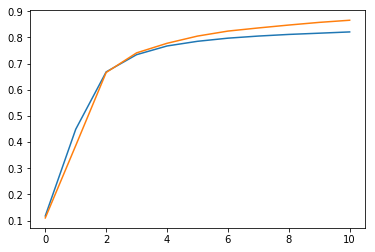

In [16]:
# Accuracy throughout training

lab5Acc = [lab5InitAcc] + lab5mHistory.history['accuracy']
convAcc = [convInitAcc] + convmHistory.history['accuracy']

plt.plot(lab5Acc)
plt.plot(convAcc)
plt.show()

Using scipy it is very simple to create a polynomial interpolation, specifically I chose to use cubic polynomal interpolation (CubicSpline).

This makes the trend in data much clearer and gives a better estimate for the true crossover point between the two accuracy histories.

Out of interest and application to the course, I will use interval bisection to find the point of intersection between the two interpolation curves.

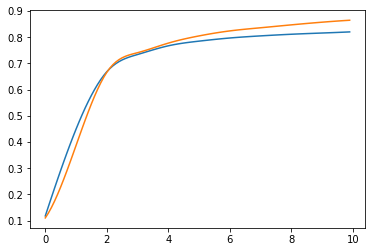

In [17]:
# Interpolate previously gathered information and plot

lab5Interp = CubicSpline(range(11), lab5Acc)
convInterp = CubicSpline(range(11), convAcc)

epochRange = np.arange(0, 10, 0.1)

lab5Range = lab5Interp(epochRange)
convRange = convInterp(epochRange)

plt.plot(epochRange, lab5Range)
plt.plot(epochRange, convRange)
plt.show()

Implementing the interval bisection algorithm as specified in class, we can easily find the crossover point between epoch 1 and 4.

To illustrate finding this point more clearly I replot the interpolation's with a vertical line to indicate crossover.

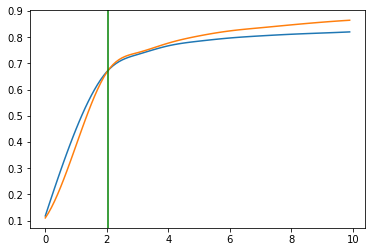

Accuracy Crossover at: 2.0517578125


In [18]:
# Interval bisection for crossover of accuracy between models

def f(x):
    return convInterp(x) - lab5Interp(x)

def interval_bisection(a, b, t):
    while(b - a > t):
        m = a + (b - a)/2
        aSign = abs(f(a))/f(a)
        mSign = abs(f(m))/f(m)
        if aSign == mSign:
            a = m
        else:
            b = m
    return a + (b - a)/2

cross = interval_bisection(1, 4, 0.01)

plt.plot(epochRange, lab5Range)
plt.plot(epochRange, convRange)
plt.axvline(x=cross, color='green')
plt.show()

print("Accuracy Crossover at: " + str(cross))

In conclusion up to this point, it seems clear that the convolutional model has a higher capacity to accurately classify images in long term training. Oddly enough the simpler, pixel specific feed forward network from lab 5 seems to train a bit more effectively from the start, up until approximately 2 epochs. Ultimately it seems clear that the convolutional model performs much better for image classification, especially given that it has less parameters to perform gradient descent on in this specific experiment.

To further analyse the impact of implementing convolutional layers in image classification I will introduce one more model which is identical to lab 5 apart from adding a single convolutional layer. This model will inherently have more parameters from going straight from the convolutional/max pooling layer into the 10 node dense layer. The intention of this model is to highlight the benefit of adding a convolutional layer.

In [23]:
# Lab 5 model with convolutional layer implementation

def lab5plusConvModel():
    model = Sequential([
        Conv2D(10, (5,5), input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(10, use_bias=True)
    ], name='Lab5PlusConvolutionalLayerModel')
    return model

lab5plusm = lab5plusConvModel()

lab5plusm.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

lab5plusm.summary()

lab5plusInitAcc = lab5plusm.evaluate(xConvTrainingData, yTrainingData, verbose=0)[1]

lab5plusmHistory = lab5plusm.fit(xConvTrainingData, yTrainingData, epochs=numberOfEpochs, verbose=1)

Model: "Lab5PlusConvolutionalLayerModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                14410     
Total params: 14,670
Trainable params: 14,670
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 151us/sample - loss: 0.0770 - accuracy: 0.5048 - loss: 0.0780 - accuracy
Epoch 2/10
20000/20000 [==============================] - 3s 143us/sampl

Here we see a clear boost in long term performance whilst also keeping up with the initial accuracy improvement from the simple lab 5 feed forward model.

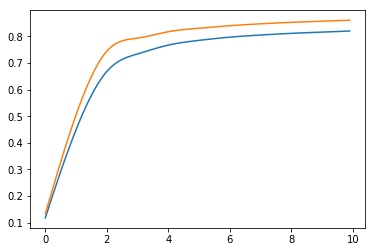

In [24]:
# Plotting training of lab 5 model with and without convolutional layer

lab5plusAcc = [lab5plusInitAcc] + lab5plusmHistory.history['accuracy']

lab5plusInterp = CubicSpline(range(11), lab5plusAcc)

lab5plusRange = lab5plusInterp(epochRange)

plt.plot(epochRange, lab5Range)
plt.plot(epochRange, lab5plusRange)
plt.show()

To wrap this whole project up, there is a clear benefit to using convolutional layers in long term training accuracy capacity. Although a regular feed forward network has a boost in initial training. Combining both convolutional layers with wide feed forward layers allows for better image feature identification in the convolutional layers in addition to the specific analysis of these features from fully connected feed forward layers come together to result in fantastic performance in image classification. If I were to continue this project I would have liked to do more complex data analysis on multiple training runs of the same models to create more comprehensive results to quantify the impact of implementing convolutional layers for image classification.

I really appreciated this project in respect to finally having an opportunity to dive into tensorflow/keras. In my other machine learning courses I have taken so far, the focus has been more about building a ML algorithm from scratch. Although I find it more satisfying to write from scratch, the ability to quickly and effectively implement ML in a real world scenario is an incredibly powerful tool that I have gotten to know much more in detail by reading through the keras documentation for implementation.